In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
print("TF: ", tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import models
from keras import Model
import keras

from pathlib import Path
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import vgg19
from sklearn.metrics import confusion_matrix, classification_report

import wandb
from wandb.keras import WandbCallback

import cv2

TF:  2.7.0


In [2]:
import seaborn as sns

def crcm(model, x, y):
    y_pred = model.predict(vgg19.preprocess_input(x))
    y_pred = np.asarray(y_pred)
    y_pred = np.uint8(y_pred+0.5)
    cm = confusion_matrix(y, y_pred)
    cr = classification_report(y, y_pred)
    plt.xlabel('Pred')
    sns.heatmap(cm, vmin=0, annot=True)
    print(cr)

In [3]:
def seed_everything():
    # os.environ['PYTHONHASHSEED'] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
    random.seed(1254)
    np.random.seed(hash("improves reproducibility") % 2**32 - 1)
    tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

seed_everything()

In [4]:

# Get base project directory

project_path = Path(os.getcwd()).parent.parent
datapath = (project_path /'data/processed/')

CLASSES = {0 : 'yes', 1 : 'no'}
# Loops through pathlist and reads and resizes images
def read_image(pathlist : list, size : int)-> list:
    data = []
    for path in pathlist:
        image=load_img(path, color_mode='rgb', target_size=(size, size))
        image=img_to_array(image)
        # image=image/255.0
        data.append(image)
    data = np.asarray(data, dtype=np.uint8)
    return data

# Makes input and label data from folder locations.
# Loops through location "subfolder/CLASSES"
def get_sets(subfolder : str, CLASSES : dict, size : int):
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        folder_paths += list((datapath / f"2_split_{v}/{subfolder}").rglob("*"))
    # Label data generation
    folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    folder_labels = np.asarray(folder_labels, dtype=np.uint8)
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels

def get_training_set(CLASSES : dict, size : int):
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        # folder_paths += list((datapath / f"3_aug_{v}_train/").rglob("*")) 3_aug_pix_no_train
        # folder_paths += list((datapath / f"3_augmentation_train/3_aug_geo_{v}_train/").rglob("*"))
        folder_paths += list((datapath / f"3_augmentation_train/3_aug_pix_{v}_train/").rglob("*"))
        # print(folder_paths)
    # Label data generation
    folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    folder_labels = np.asarray(folder_labels, dtype=np.uint8)
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels

Load Pictures

In [5]:
# Dataset inspect
# Read images to variables
size = 224
X_aug_train, y_aug_train = get_training_set(CLASSES, size)
X_train, y_train = get_sets('train', CLASSES, size)
X_val, y_val = get_sets('val', CLASSES, size)
X_test, y_test = get_sets('test', CLASSES, size)

Config parameters

In [6]:
# Mind model processing
# Finetune not complete
configs = dict(
    project_name = "MRI_Baseline_3", #Project Name
    mode = 'run', #{'offline', 'run', 'disabled', 'dryrun', 'online'} # WandB run status
    job_type = "", #Run type for WandB
    group = "", # Group in WandB
    sub_group = "_test_sweep_param_s2",

    class_names = CLASSES, # Classes for training
    training_set = "",

    image_width = X_train[0].shape[0], # Picture width for model input
    image_height = X_train[0].shape[1], # Picture height for model input
    image_channels = X_train[0].shape[2], # Picture channels for model input

    pretrain_weights = 'imagenet', # pretrained weights for basemodel if any
    batch_size = 4, # Batchsize for training
    init_learning_rate = 0.001, # Initial training rate if no callback is used
    lr_decay_rate = 0.1, #decayrate of training rate
    epochs = 50, # Epochs to train
    optimizer = 'rmsprop', # The optimizer used by the ml model
    loss_fn = 'binary_crossentropy', # Loss function
    metrics = ['accuracy'], # Metrics
    earlystopping_patience = 5, # For the early stopping callback

    dataset = "Brain_MRI_Images_for_Brain_Tumor_Detection",
    fine_tune_learning_rate = 1e-5, # learningrate Used during fine tuning
    fine_tune_epochs = 10, # Epochs ran at finetuning

    architecture = "",# To be defined f"{base_model._name.upper()} global_average_pooling2d",
    model_name = '' # set after model is defined # Name of the ml Model

)

In [7]:
model_filename = f'vanillacheck.h5'

checkpoint_filepath = (Path(os.getcwd()) /f'model_checkpoint/{model_filename}')

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [8]:
# tf.keras.backend.clear_session()
# kwarg = dict(weights='imagenet', include_top=False, input_shape=(224,224,3))
# base_model = vgg19.VGG19(**kwarg)
# base_model.trainable = False

# x = layers.GlobalAveragePooling2D()(base_model.output)

# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dense(64, activation='relu')(x)
# x = layers.Dense(32, activation='relu')(x)
# outputs = layers.Dense(1, activation='sigmoid')(x)

# model  = models.Model(base_model.input, outputs, name=f'{base_model._name.upper()}')

In [5]:
import tensorflow as tf
import keras
tf.keras.backend.clear_session()

model = keras.models.load_model('model_checkpoint/vanillacheck')

OSError: No file or directory found at model_checkpoint/vanillacheck

Transfer Learning

In [9]:
callbacks = [model_checkpoint_callback]
verbose = 2

Epoch 1/50
79/79 - 23s - loss: 0.5087 - accuracy: 0.7836 - val_loss: 0.4358 - val_accuracy: 0.8333 - 23s/epoch - 289ms/step
Epoch 2/50
79/79 - 11s - loss: 0.2948 - accuracy: 0.8696 - val_loss: 0.3713 - val_accuracy: 0.8333 - 11s/epoch - 136ms/step
Epoch 3/50
79/79 - 11s - loss: 0.1989 - accuracy: 0.9240 - val_loss: 0.3016 - val_accuracy: 0.8333 - 11s/epoch - 138ms/step
Epoch 4/50
79/79 - 11s - loss: 0.1461 - accuracy: 0.9424 - val_loss: 0.3598 - val_accuracy: 0.8571 - 11s/epoch - 141ms/step
Epoch 5/50
79/79 - 11s - loss: 0.1127 - accuracy: 0.9600 - val_loss: 0.7016 - val_accuracy: 0.8810 - 11s/epoch - 141ms/step
Epoch 6/50
79/79 - 11s - loss: 0.0714 - accuracy: 0.9704 - val_loss: 0.3838 - val_accuracy: 0.8333 - 11s/epoch - 134ms/step
Epoch 7/50
79/79 - 11s - loss: 0.0566 - accuracy: 0.9768 - val_loss: 0.3958 - val_accuracy: 0.8810 - 11s/epoch - 135ms/step
Epoch 8/50
79/79 - 11s - loss: 0.0430 - accuracy: 0.9836 - val_loss: 0.5684 - val_accuracy: 0.8571 - 11s/epoch - 135ms/step
Epoch 9/

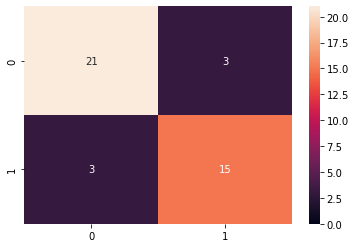

In [10]:

train_config = {
    "learning_rate" : configs['init_learning_rate'],
    "epochs" : configs['epochs'],
    "compile" : True}
configs['job_type'] = "Transfer learning"

base_model.trainable = False


opt = tf.keras.optimizers.RMSprop(learning_rate=configs['init_learning_rate'])
model.compile(optimizer=opt,
            loss=configs['loss_fn'],
            metrics=configs['metrics'])
            
model.fit(vgg19.preprocess_input(X_aug_train), y_aug_train,
            epochs=train_config['epochs'],
            validation_data=(vgg19.preprocess_input(X_val), y_val),
            callbacks=callbacks,
            verbose=verbose)
crcm(model, X_val, y_val)

Model class definition

Epoch 1/10
79/79 - 41s - loss: 0.3687 - accuracy: 0.9676 - val_loss: 1.1811 - val_accuracy: 0.8571 - 41s/epoch - 520ms/step
Epoch 2/10
79/79 - 36s - loss: 0.0805 - accuracy: 0.9800 - val_loss: 1.1766 - val_accuracy: 0.8571 - 36s/epoch - 452ms/step
Epoch 3/10
79/79 - 36s - loss: 0.0433 - accuracy: 0.9928 - val_loss: 1.1663 - val_accuracy: 0.9048 - 36s/epoch - 453ms/step
Epoch 4/10
79/79 - 36s - loss: 0.0828 - accuracy: 0.9860 - val_loss: 1.3448 - val_accuracy: 0.8095 - 36s/epoch - 455ms/step
Epoch 5/10
79/79 - 36s - loss: 0.0294 - accuracy: 0.9924 - val_loss: 1.1111 - val_accuracy: 0.8095 - 36s/epoch - 456ms/step
Epoch 6/10
79/79 - 36s - loss: 0.0265 - accuracy: 0.9960 - val_loss: 0.9477 - val_accuracy: 0.8810 - 36s/epoch - 456ms/step
Epoch 7/10
79/79 - 36s - loss: 0.0307 - accuracy: 0.9936 - val_loss: 1.3833 - val_accuracy: 0.7857 - 36s/epoch - 455ms/step
Epoch 8/10
79/79 - 36s - loss: 3.2320e-04 - accuracy: 1.0000 - val_loss: 1.5842 - val_accuracy: 0.8810 - 36s/epoch - 454ms/step
Epoc

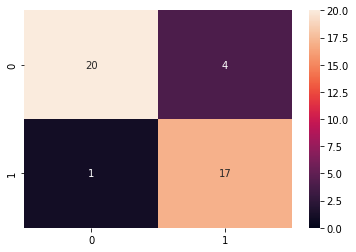

In [11]:

opt = tf.keras.optimizers.RMSprop(learning_rate=configs['fine_tune_learning_rate'])
base_model.trainable = True
model.compile(optimizer=opt,
            loss=configs['loss_fn'],
            metrics=configs['metrics'])



# Train model
model.fit(vgg19.preprocess_input(X_aug_train), y_aug_train,
            epochs=configs['fine_tune_epochs'],
        validation_data=(vgg19.preprocess_input(X_val), y_val),
            callbacks=callbacks,
            verbose=verbose)
crcm(model, X_val, y_val)


Call model

Model Callbacks